# Prepare PPI Network
In this notebook, I want to collect the protein-protein-interaction (PPI) network from ConsensusPathDB and preprocess it.
The preprocessing contains the following steps:
* Filter out "complex" interactions (more than two partners)
* Filter out interactions with score < 0.5
* Map the strange uniprot gene names to ENSEMBL IDs (either protein IDs or gene IDs)
* Convert the resulting edgelist to an adjacency matrix
* Export the edgelist to .sif (can be read by cytoscape directly)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mygene
import h5py
%matplotlib inline

In [2]:
def save_sif(edgelist, outfile):
    print ("Saving edgelist to {}".format(outfile))
    with open(outfile, 'w') as out:
        for idx, row in edgelist.iterrows():
            out.write('{} (interacts) {}\n'.format(row.partner1, row.partner2))
    print (".sif successfully saved!")

## Get  all interactions
Now I want to load all the interactions and build an edgelist from them. Once I have that edgelist, I can construct an adjacency matrix from it.

In [3]:
interactions = pd.DataFrame.from_csv('../../data/networks/ConsensusPathDB_human_PPI.csv',
                                     header=1,
                                     sep='\t',
                                     encoding='utf8'
                                    )
interactions_nona = interactions.dropna()
interactions_nona.head()

,interaction_publications,interaction_participants,interaction_confidence
# source_databases,,,
"Spike,PhosphoPOINT,Biogrid,HPRD,Reactome","1660465,16713569,12547834","ANF_HUMAN,ANPRA_HUMAN",0.026242
"Biogrid,HPRD,Reactome,PhosphoPOINT","12709393,1672777,1309330,1660465","ANFC_HUMAN,ANPRB_HUMAN",0.008239
"DIP,Reactome","22210847,17486119,21408196,16906149,19897728","STIM1_HUMAN,TRPC1_HUMAN",0.998803
"Reactome,HPRD",11591728,"AT2B4_HUMAN,NOS1_HUMAN",0.798424
"Reactome,HPRD,BIND,MIPS-MPPI,IntAct","10093054,23587463","KCJ11_HUMAN,ABCC9_HUMAN",0.999998


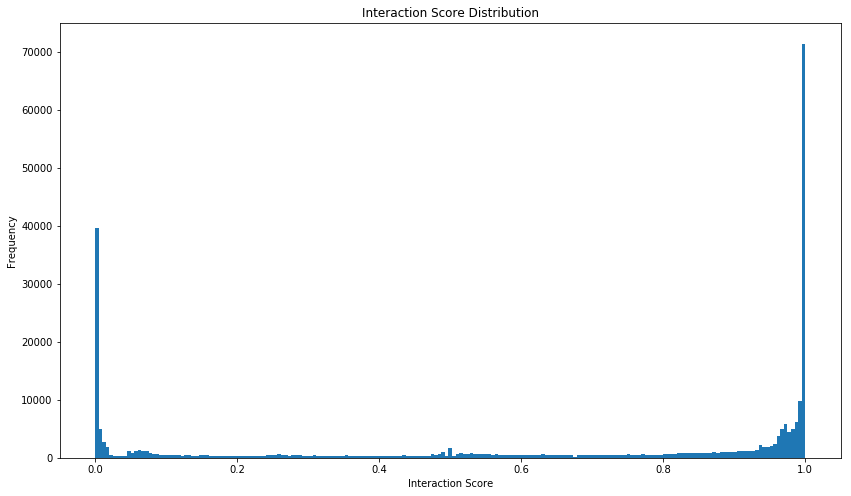

In [4]:
bins = np.linspace(0, 1, 200)
fig = plt.figure(figsize=(14, 8))
ax = plt.hist(interactions_nona.interaction_confidence, bins)
plt.xlabel('Interaction Score')
plt.ylabel('Frequency')
plt.title('Interaction Score Distribution')

## Remove "complex" interactions & low confidence

In [5]:
# select interactions with exactly two partners
binary_inter = interactions_nona[interactions_nona.interaction_participants.str.count(',') == 1]
# split the interactions columns into interaction partners
edgelist = pd.concat([binary_inter.interaction_participants.str.split(',', expand=True),
                                binary_inter.interaction_confidence], axis=1
                              )
# make the dataframe beautiful
edgelist.set_index([np.arange(edgelist.shape[0])], inplace=True)
edgelist.columns = ['partner1', 'partner2', 'confidence']
edgelist.to_csv('../../data/networks/CPDB_uni_edgelist.tsv', sep='\t')

# select interactions with confidence score above threshold
high_conf_edgelist = edgelist[edgelist.confidence > .5]

edgelist.head()

,partner1,partner2,confidence
0,ANF_HUMAN,ANPRA_HUMAN,0.026242
1,ANFC_HUMAN,ANPRB_HUMAN,0.008239
2,STIM1_HUMAN,TRPC1_HUMAN,0.998803
3,AT2B4_HUMAN,NOS1_HUMAN,0.798424
4,KCJ11_HUMAN,ABCC9_HUMAN,0.999998


In [13]:
interactions.shape, interactions_nona.shape, edgelist.shape, high_conf_edgelist.shape

((291415, 3), (272744, 3), (272744, 3), (178345, 3))

## Map from Uniprot Name to Ensembl ID
This is not simple at all. We have to write both columns with the interaction partners to file and then use the uniprot webservice (http://www.uniprot.org/mapping/) to do the mapping. The resulting csv files then have to be read again to form the correct edgelist for us.

In [33]:
# write involved uniprot names to file
uniprot_names = edgelist.partner1.append(edgelist.partner2).unique()
np.savetxt('../../data/networks/uniprot_names.txt', uniprot_names, fmt='%s')

In [50]:
# Build a uniprot mapping manually using the webservice :-(
# load the mapped partners
mapping = pd.read_csv('../../data/networks/uniprot_ensg_mapping.tsv',
                              sep='\t',
                              header=0,
                              names=['ensembl']
                             )

# get them into our dataframe (size increases because of duplicates in mapping)
# that is, one uniprot gene name has multiple ensembl gene names, hence we have to add those interactions
p1_incl = high_conf_edgelist.join(mapping, on='partner1', how='inner', rsuffix='_p1')
both_incl = p1_incl.join(mapping, on='partner2', how='inner', rsuffix='_p2')
both_incl.columns = ['partner1', 'partner2', 'confidence', 'partner1_ensembl', 'partner2_ensembl']

# collect statistics on how many interactions we lost
num_unmaps = both_incl[both_incl.partner1_ensembl.isnull() | both_incl.partner2_ensembl.isnull()].shape[0]
num_p1_unmaps = p1_incl[p1_incl.ensembl.isnull()].partner1.unique().shape[0]
num_p2_unmaps = both_incl[both_incl.partner2_ensembl.isnull()].partner2.unique().shape[0]
print ("We were unable to map {} source and {} target genes.".format(num_p1_unmaps, num_p2_unmaps))
print ("We lost {} interactions this way.".format(num_unmaps))

# kick out the NaNs and remove uniprot names (hate them)
final_edgelist = both_incl.dropna(axis=0)
final_edgelist.drop(['partner1', 'partner2'], axis=1, inplace=True)
print ("Final edge list has {} interactions".format(final_edgelist.shape[0]))

# sort by number and put confidence at last and rename columns
final_edgelist.sort_index(inplace=True)
cols = final_edgelist.columns.tolist()
cols = cols[1:] + [cols[0]]
final_edgelist = final_edgelist[cols]
final_edgelist.columns = ['partner1', 'partner2', 'confidence']

# write to file and look at the first rows
final_edgelist.to_csv('../../data/networks/CPDB_ensg_edgelist.tsv', sep='\t')
save_sif(final_edgelist, '../../data/networks/CPDB_ensg_edgelist.sif')
final_edgelist.head()

We were unable to map 0 source and 0 target genes.
We lost 0 interactions this way.
Final edge list has 218372 interactions


,partner1,partner2,confidence
2,ENSG00000167323,ENSG00000144935,0.998803
3,ENSG00000058668,ENSG00000089250,0.798424
4,ENSG00000187486,ENSG00000069431,0.999998
5,ENSG00000084754,ENSG00000138029,1.000000
6,ENSG00000153767,ENSG00000197265,0.999970


## Construct Adjacency Matrix

In [52]:
adjacency_matrix = final_edgelist.pivot('partner1', 'partner2', 'confidence')
adjacency_matrix[~adjacency_matrix.isnull()] = 1
adjacency_matrix[adjacency_matrix.isnull()] = 0

In [53]:
avg_node_degree = adjacency_matrix.sum().mean()
total_num_of_connections = adjacency_matrix.sum().sum()
print ("Constructed Adjacency Matrix with average node degree of: {}".format(avg_node_degree))
print ("Adjacency matrix has {} edges in total".format(total_num_of_connections))

Constructed Adjacency Matrix with average node degree of: 17.67621822891371
Adjacency matrix has 218372.0 edges in total


## Store Adjacency matrix on Disk

In [54]:
f = h5py.File('../../data/networks/CPDB_ppi_ens.h5', 'w')
f.create_dataset('consensusPathDB_ppi', data=adjacency_matrix, shape=adjacency_matrix.shape)
f.close()